# The Algorithm from *Trajectory Recovery from Ash: User Privacy is NOT Preserved in Aggregated Mobility Data* by Xu et. al (2017)

This notebook provides an explanation and implementation of the algorithm presented in the aforementioned research paper. We evaluate the algorithm on two open-source datasets: PortoTaxi and GeoLife. This completes the target goals 1 and 2 specified by the *Trajectory Recovery from Ash: In the Age of A.I.* project for UNSW's COMP9900 24T1.

The class details are: *FromAsh, COMP9900, W18A*.

This notebook can also be run on Google Colab with the following credentials:
- Username: hacjerx121@gmail.com
- Password: Trajectory121

## 1 Preliminaries

This section imports all dependencies and defines functions as required. The functions are direct implementations of the formulae described in Xu et. al's paper.

### 1.1 Dependencies

The following cell is for loading google drive. If running locally, remove the first two lines and set the `PATH` to the directory containing the data. The data is assumed to contain two folders each for the two datasets used. Change file paths as necessary.

In [1]:
from google.colab import drive
drive.mount('/content/drive')
PATH = "/content/drive/MyDrive"

Mounted at /content/drive


In [22]:
import os
import ast
import math
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt

###  1.2 Functions

In [ ]:
def trajectory_entropy(trajectory):
    freq = [0 for _ in range(max(trajectory)+1)]
    for x in trajectory:
        freq[x] += 1
    result = 0
    for f in [x for x in freq if x > 0]:
        result -= (f/len(trajectory))*math.log2(f/len(trajectory))
    return result

def trajectory_gain(trajectory_1, trajectory_2):
    return trajectory_entropy(trajectory_1 + trajectory_2) - ((
                   trajectory_entropy(trajectory_1) +
                   trajectory_entropy(trajectory_2)
               ) / 2
           )

def preview_matrix(matrix, rows, cols):
    for i in range(rows):
        print(matrix[i][:cols])

def uniqueness(data, k):
    top_k_locs = [set() for _ in range(len(data))]
    for u in range(len(data)):
        freq = dict()
        for l in range(len(data[0])):
            if data[u][l] not in freq.keys():
                freq[data[u][l]] = 1
            else:
                freq[data[u][l]] += 1
        freq = sorted([(k, v) for k, v in freq.items()], key=lambda x: x[1], reverse=True)
        top_k_locs[u] = set([x[0] for x in freq][:k])
    return len(set(map(frozenset, top_k_locs))) / len(data)

## 2 The Algorithm, in Detailed Stages

In this section, we present the algorithm, as outlined in Xu et. al. (2017), step-by-step. We use an example dataset to demonstrate this.

### 2.1 Data Loading

This dataset is aggregated by a $3 \times 3$ grid, meaning there are 9 distinct locations. There are 197 user's trajectories and 4321 timesteps.

Both have an interval of 10 minutes, thus there are 144 steps per day. Indices $[0, 35]$ account for times 00:00 to 05:50, and indices $[36, 143]$ account for times 06:00 to 23:50.

To use a particular version, uncomment and run only one of the two following cells, then continue.

Throughout the code, $N$ refers to the number of users/trajectories in the dataset, $M$ is the number of locations, $T$ is the number of timesteps, and $D$ is the number of intervals in one day.

In [ ]:
agg = pd.read_csv(os.path.join(PATH, "PortoTaxi/Porto taxi aggregated 3x3.csv"))
grid = pd.read_csv(os.path.join(PATH, "PortoTaxi/Porto taxi grid 3x3.csv"))
truth_data = pd.read_csv(os.path.join(PATH, "PortoTaxi/ground_truth 3x3.csv"))
N = 197
M = 49
T = 4321
D = 144

We now need to get the data into the correct format:

- Input:
  - Aggregated dataset as a `pandas.DataFrame`, with $T$ rows and $M$ columns. Rows must appear in chronological order (i.e. by timestep). The order of columns (locations) from left to right will be used throughout the notebook. We require that the dataset begins at 00:00.
  - Location information as a `dict`. This should map the $i$, (where $i$ is the $i$-th location) to a tuple representing its real location in terms of **cartesian** lattitude/longitude coordinates.

- Truth:
  - A 2D ($N$ rows, $T$ columns) `list` or `np.array` of the true trajectories. The order of rows is not important, but each trajectory must contain the locations in chronological order. Each element is a **cartesian** lattitude/longitude tuple.
  - Note that this is **not** input into the algorithm, only used for evaluation.

---

We also need to set up some auxiliary data structures that are required for executing the algorithm:

- `locs` keeps track of which column in the cost matrix refers to what locations at each timestep (because this changes). It stores a `dict` for each timestep in a `list`.

- `pred` is an $N \times T$ list that will store the predicted trajectories. The first timestep for each day is filled in here as well.

In [ ]:
agg = agg.drop("datetime", axis=1)
grid = grid.drop(["index", "bottomleft", "topright"], axis=1)
grid = grid.T.to_dict()
for k, v in grid.items():
    grid[k] = ast.literal_eval(v["towerlocation"])

truth_data.reset_index(inplace=True)
truth_data["ordered_towers"] = truth_data.apply(lambda x: (x["index"], x["tower"]), axis=1)
truth = []
for trajectory in truth_data.groupby("TAXI_ID")["ordered_towers"].apply(list):
    tmp = sorted(trajectory, key=lambda x: x[0])
    truth.append([ast.literal_eval(x[1]) for x in tmp])

locs = [dict() for _ in range(T)] # Records which column refers to what location at each timestep
pred = [[-1]*T for _ in range(N)] # Stores the predicted trajectories

for i in range(T):
    a = agg.iloc[[i]].values[0]
    tmp = 0
    for j, val in enumerate(a):
        for k in range(int(val)):
            locs[i][tmp+k] = j
            if i % D == 0: # insert starting points for each day
                pred[tmp+k][i] = j
        tmp += int(val)

### 2.2 Nighttime Trajectory Recovery

Recall that timesteps that are relevant to nighttime are 00:00 - 06:00. This is when $i \mod D < \lfloor D/4 \rfloor $, where $0 \le i < T$.

For these timesteps, we create a cost matrix and run the Linear Sum Assignment algorithm (an optimized version of the Hungarian Algorithm from the `scipy` library) to generate the next set of locations that minimize cost. The costs here are based on geographical distance.

In [ ]:
for i in [x for x in range(T) if x % D < D // 4 and x + 1 < T]:
    if i % D == 0: print(f"Night {i//D} processing...")
    cost = np.zeros((N,N))
    for u in range(N): # users
        for l in range(N): # locations
            loc_i = grid[pred[u][i]]
            loc_j = grid[locs[i+1][l]]
            cost[u][l] = math.dist(loc_i, loc_j)
    row_assn, col_assn = scipy.optimize.linear_sum_assignment(cost, maximize=False)
    for u, l in enumerate(col_assn):
        pred[u][i+1] = locs[i+1][l]

preview_matrix(pred, 10, D // 4)

Night 0 processing...
Night 1 processing...
Night 2 processing...
Night 3 processing...
Night 4 processing...
Night 5 processing...
Night 6 processing...
Night 7 processing...
Night 8 processing...
Night 9 processing...
Night 10 processing...
Night 11 processing...
Night 12 processing...
Night 13 processing...
Night 14 processing...
Night 15 processing...
Night 16 processing...
Night 17 processing...
Night 18 processing...
Night 19 processing...
Night 20 processing...
Night 21 processing...
Night 22 processing...
Night 23 processing...
Night 24 processing...
Night 25 processing...
Night 26 processing...
Night 27 processing...
Night 28 processing...
Night 29 processing...
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

### 2.3 Daytime Trajectory Recovery

Recall that timesteps that are relevant to daytime are 06:00 - 24:00 (end of day). This is when $i \mod D \ge \lfloor D/4 \rfloor$, where $0 \le i < T$.

For these timesteps, we create a cost matrix and run the Linear Sum Assignment algorithm to generate the next set of locations that minimize cost. The costs here are based on geographical distance from the next estimated location. The next estimated location is provided by a velocity equation in Xu et. al.'s paper: "$l_i^{t+1} = q_i^t + (q_i^t - q_i^{t-1})$, where $l_i^{t+1}$ is the next estimated location for the $i$-th trajectory, and $q_i^t$ is the location at timestamp $t$ for the same trajectory."

In [ ]:
for i in [x for x in range(T) if x % D >= D // 4 and x+1 < T]:
    if i % D == D // 4: print(f"Day {i // D} processing...")
    cost = np.zeros((N,N))
    for u in range(N): # users
        for l in range(N): # locations
            q_t = grid[pred[u][i]]
            q_t1 = grid[pred[u][i-1]]
            loc_i = (q_t[0]+(q_t[0]-q_t1[0]), q_t[1]+(q_t[1]-q_t1[1]))
            loc_j = grid[locs[i+1][l]]
            cost[u][l] = math.dist(loc_i, loc_j)
    row_assn, col_assn = scipy.optimize.linear_sum_assignment(cost, maximize=False)
    for u, l in enumerate(col_assn):
        pred[u][i+1] = locs[i+1][l]

preview_matrix(pred, 10, D)

Day 0 processing...
Day 1 processing...
Day 2 processing...
Day 3 processing...
Day 4 processing...
Day 5 processing...
Day 6 processing...
Day 7 processing...
Day 8 processing...
Day 9 processing...
Day 10 processing...
Day 11 processing...
Day 12 processing...
Day 13 processing...
Day 14 processing...
Day 15 processing...
Day 16 processing...
Day 17 processing...
Day 18 processing...
Day 19 processing...
Day 20 processing...
Day 21 processing...
Day 22 processing...
Day 23 processing...
Day 24 processing...
Day 25 processing...
Day 26 processing...
Day 27 processing...
Day 28 processing...
Day 29 processing...
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 8, 5, 2, 4, 3, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5

### 2.4 Across Days Trajectory Recovery

We now have subtrajectories for $N$ people over $T$ timesteps. However, we cannot say that we have their full trajectories as we have not yet linked the end of one day (e.g. 23:59) to the start of the next day (00:00). This next stage links trajectories from day to day, still using the linear sum assignment algorithm, but using information gain and entropy to generate values for the cost matrix.

In [ ]:
for i in range(N):
    pred[i] = [pred[i][j:j+D] for j in range(0,T,D)]

days = [[x[i] for x in pred] for i in range(math.ceil(T/D))]
links = [None for _ in range(len(days)-1)]

for i in range(len(days)-1):
    print(f"Day {i} processing...")
    cost = np.zeros((N,N))
    for a in range(N): # trajectory i
        for b in range(N): # trajectory j
            cost[a][b] = trajectory_gain(days[i][a], days[i+1][b])
    row_assn, col_assn = scipy.optimize.linear_sum_assignment(cost, maximize=False)
    links[i] = col_assn

Day 0 processing...
Day 1 processing...
Day 2 processing...
Day 3 processing...
Day 4 processing...
Day 5 processing...
Day 6 processing...
Day 7 processing...
Day 8 processing...
Day 9 processing...
Day 10 processing...
Day 11 processing...
Day 12 processing...
Day 13 processing...
Day 14 processing...
Day 15 processing...
Day 16 processing...
Day 17 processing...
Day 18 processing...
Day 19 processing...
Day 20 processing...
Day 21 processing...
Day 22 processing...
Day 23 processing...
Day 24 processing...
Day 25 processing...
Day 26 processing...
Day 27 processing...
Day 28 processing...
Day 29 processing...


We recover the result and get it back into the desired format.

In [ ]:
pred = [days[0][i] for i in range(N)]
for i in range(N): # users
    curr_row = i
    for j in range(len(days)-1): # days
        next_row = links[j][curr_row]
        pred[i] = pred[i] + days[j+1][next_row]
        curr_row = next_row

preview_matrix(pred, 10, T)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 8, 5, 2, 4, 3, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 8, 7, 6, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 3, 3, 3, 3, 3, 3, 6, 6, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

### 2.5 Evaluation

Recall that:
  - `truth` is a list of lists $[[1..T]..N]$ where each element is a cartesian lattitude/longitude tuple.
  - `pred` is a list of lists $[[1..T]..N]$ where each element contains a location-ID (that can be mapped back to the location tuple using `grid`).

---

When we associate a predicted trajectory to a true trajectory, we use a greedy approach (as done in the paper), and pair trajectories that have the least recovery error. Each trajectory must be uniquely linked, so the Linear Sum Assignment algorithm is run once again to link trajectories with the least recovery error. The `compare` list records the associations as: `compare[i] = j` means that the $i$-th predicted trajectory is associated with the $j$-th true trajectory.


The three metrics in the paper are:
  - Accuracy: The ratio of points that are correct.
  - Recovery Error: The euclidean distance of error.
  - Uniqueness: Percentage of trajectories that can be uniquely distinguished by their most frequent $k$ locations. We mirror the paper and restrict $k$ to be $1 \le k \le 5$. (It is noted that commonly, $k=2$).

In [ ]:
accuracy = 0
recovery_error = 0

accuracy_matrix = np.zeros((N,N))
error_matrix = np.zeros((N,N))

for i in range(N): # predicted trajectories
    print(f"Evaluating trajectory {i}...")
    for j in range(N): # truth trajectories
        error = 0
        acc = 0
        for k in range(T): # timesteps
            pred_loc = grid[pred[i][k]]
            x = math.dist(pred_loc, truth[j][k])
            error += x # location error
            if x == 0: # accuracy
                acc += 1
        error_matrix[i][j] = error
        accuracy_matrix[i][j] = acc / T

#compare[i] = j means the i-th predicted trajectory matches the j-th true trajectory.
_, compare = scipy.optimize.linear_sum_assignment(error_matrix, maximize=False)

for i, j in enumerate(compare):
    accuracy += accuracy_matrix[i][j] / N
    recovery_error += error_matrix[i][j]

print(f"Accuracy: {accuracy}")
print(f"Recovery Error: {recovery_error}")
for i in range(1,6):
    print(f"Uniqueness (k={i}), Predicted: {uniqueness(pred, i)}")
    print(f"Uniqueness (k={i}), Truth: {uniqueness(truth, i)}")
print(compare)

Evaluating trajectory 0...
Evaluating trajectory 1...
Evaluating trajectory 2...
Evaluating trajectory 3...
Evaluating trajectory 4...
Evaluating trajectory 5...
Evaluating trajectory 6...
Evaluating trajectory 7...
Evaluating trajectory 8...
Evaluating trajectory 9...
Evaluating trajectory 10...
Evaluating trajectory 11...
Evaluating trajectory 12...
Evaluating trajectory 13...
Evaluating trajectory 14...
Evaluating trajectory 15...
Evaluating trajectory 16...
Evaluating trajectory 17...
Evaluating trajectory 18...
Evaluating trajectory 19...
Evaluating trajectory 20...
Evaluating trajectory 21...
Evaluating trajectory 22...
Evaluating trajectory 23...
Evaluating trajectory 24...
Evaluating trajectory 25...
Evaluating trajectory 26...
Evaluating trajectory 27...
Evaluating trajectory 28...
Evaluating trajectory 29...
Evaluating trajectory 30...
Evaluating trajectory 31...
Evaluating trajectory 32...
Evaluating trajectory 33...
Evaluating trajectory 34...
Evaluating trajectory 35...
Ev

### 2.6 Visualisation

The following cell allows us to visualise and compare the recovered trajectories to their associated true trajectories. You may change the `trajectory_choice` and `length_choice` variables to any value within $[0, N)$ and $[0, T)$ respectively to show specific results.

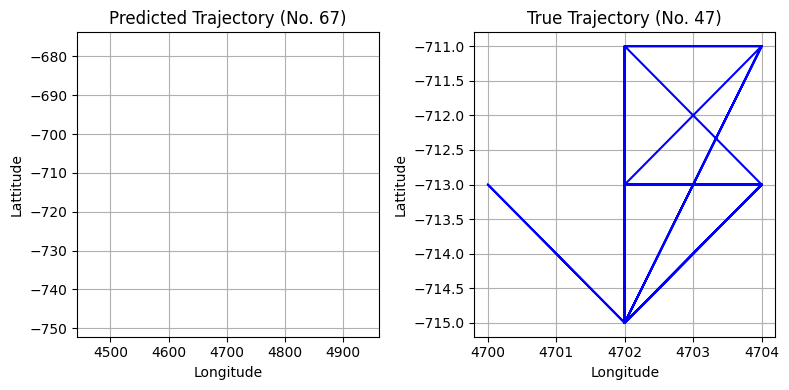

In [ ]:
import random

trajectory_choice = random.randint(0,N-1)
length_choice = 144

pred_traj = pred[trajectory_choice][:length_choice]
pred_traj = [grid[x] for x in pred_traj]
true_traj = truth[compare[trajectory_choice]][:length_choice]

x1, y1 = zip(*pred_traj)
x2, y2 = zip(*true_traj)
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

axs[0].plot(x1, y1, color='red')
axs[0].set_title(f'Predicted Trajectory (No. {trajectory_choice})')
axs[0].set_xlabel('Longitude')
axs[0].set_ylabel('Lattitude')
axs[0].grid()

axs[1].plot(x2, y2, color='blue')
axs[1].set_title(f'True Trajectory (No. {compare[trajectory_choice]})')
axs[1].set_xlabel('Longitude')
axs[1].set_ylabel('Lattitude')
axs[1].grid()

plt.tight_layout()
plt.show()

## 3 Usage and Evaluation on Real Datasets

### 3.1 The Class

We restructure the above process into a class for ease of use. The class constructor accepts correctly-formatted datasets (as described in Section 2.1), which can then be fed into the algorithm for evaluating.

The dependencies are: `math`, `pandas`, `numpy`, `scipy`, and `matplotlib.pyplot` (imported as `plt`).

In [5]:
import math
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt


class TrajectoryRecovery():
    def __init__(
        self,
        aggregated_dataset: pd.DataFrame,
        grid: dict,
        num_trajectories: int,
        num_locations: int,
        num_timesteps: int,
        num_intervals_per_day: int
    ):
        self.agg = aggregated_dataset
        self.truth = None
        self.grid = grid
        self.N = num_trajectories
        self.M = num_locations
        self.T = num_timesteps
        self.D = num_intervals_per_day
        self.locs = [dict() for _ in range(self.T)]
        self.pred = [[-1]*self.T for _ in range(self.N)]
        self.result = None

        for i in range(self.T):
            row = aggregated_dataset.iloc[[i]].values[0]
            tmp = 0
            for j, val in enumerate(row):
                for k in range(int(val)):
                    self.locs[i][tmp+k] = j
                    if i % self.D == 0:
                        self.pred[tmp+k][i] = j
                tmp += int(val)


    def run_algorithm(self, verbose=False):
        self.__night__(verbose)
        self.__day__(verbose)
        self.__across__(verbose)


    def __night__(self, verbose=False):
        if verbose:
            print("Starting nighttime trajectory recovery process.")

        cost = np.zeros((self.N, self.N))
        for i in [x for x in range(self.T) if x % self.D < self.D // 4 and x + 1 < self.T]:
            if verbose and i % self.D == 0:
                print(f"Night {i // self.D} processing...")
            for u in range(self.N):
                for l in range(self.N):
                    loc_i = self.grid[self.pred[u][i]]
                    loc_j = self.grid[self.locs[i+1][l]]
                    cost[u][l] = math.dist(loc_i, loc_j)
            row_assn, col_assn = scipy.optimize.linear_sum_assignment(cost, maximize=False)
            for u, l in enumerate(col_assn):
                self.pred[u][i+1] = self.locs[i+1][l]
        if verbose:
            TrajectoryRecovery.preview_matrix(self.pred, 10, self.D // 4)
            print()


    def __day__(self, verbose=False):
        if verbose:
            print("Starting daytime trajectory recovery process.")

        cost = np.zeros((self.N, self.N))
        for i in [x for x in range(self.T) if x % self.D >= self.D // 4 and x + 1 < self.T]:
            if verbose and i % self.D == self.D // 4:
                print(f"Day {i // self.D} processing...")
            for u in range(self.N):
                for l in range(self.N):
                    q_t = self.grid[self.pred[u][i]]
                    q_t1 = self.grid[self.pred[u][i-1]]
                    loc_i = (q_t[0]+(q_t[0]-q_t1[0]), q_t[1]+(q_t[1]-q_t1[1]))
                    loc_j = self.grid[self.locs[i+1][l]]
                    cost[u][l] = math.dist(loc_i, loc_j)
            row_assn, col_assn = scipy.optimize.linear_sum_assignment(cost, maximize=False)
            for u, l in enumerate(col_assn):
                self.pred[u][i+1] = self.locs[i+1][l]
        if verbose:
            TrajectoryRecovery.preview_matrix(self.pred, 10, self.D)
            print()


    def __across__(self, verbose=False):
        if verbose:
            print("Starting subtrajectory linking process.")

        for i in range(self.N):
            self.pred[i] = [self.pred[i][j:j+self.D] for j in range(0, self.T, self.D)]

        days = [[x[i] for x in self.pred] for i in range(math.ceil(self.T / self.D))]
        links = [None for _ in range(len(days)-1)]
        cost = np.zeros((self.N, self.N))
        for i in range(len(days)-1):
            if verbose:
                print(f"Day {i} processing...")
            for a in range(self.N):
                for b in range(self.N):
                    cost[a][b] = TrajectoryRecovery.gain(days[i][a], days[i+1][b])
            row_assn, col_assn = scipy.optimize.linear_sum_assignment(cost, maximize=False)
            links[i] = col_assn

        self.pred = [days[0][i] for i in range(self.N)]
        for i in range(self.N):
            curr_row = i
            for j in range(len(days)-1):
                next_row = links[j][curr_row]
                self.pred[i] = self.pred[i] + days[j+1][next_row]
                curr_row = next_row
        if verbose:
            TrajectoryRecovery.preview_matrix(self.pred, 10, self.T)
            print()


    def evaluate(self, truth_dataset: list[list], verbose=False):
        if verbose:
            print("Starting evaluation process.")
        self.truth = truth_dataset
        self.compare = []
        self.result = {
            'accuracy': 0,
            'recovery_error': 0,
            'uniqueness': {
                'predicted': dict(),
                'truth': dict(),
            }
        }

        accuracy_matrix = np.zeros((self.N,self.N))
        error_matrix = np.zeros((self.N,self.N))
        for i in range(self.N): # predicted trajectories
            print(f"Evaluating trajectory {i}...")
            for j in range(self.N): # truth trajectories
                error = 0
                acc = 0
                for k in range(self.T): # timesteps
                    pred_loc = self.grid[self.pred[i][k]]
                    x = math.dist(pred_loc, self.truth[j][k])
                    error += x # location error
                    if x == 0: # accuracy
                        acc += 1
                error_matrix[i][j] = error
                accuracy_matrix[i][j] = acc / self.T

        #compare[i] = j means the i-th predicted trajectory matches the j-th true trajectory.
        _, self.compare = scipy.optimize.linear_sum_assignment(error_matrix, maximize=False)

        for i, j in enumerate(self.compare):
            self.result['accuracy'] += accuracy_matrix[i][j] / self.N
            self.result['recovery_error'] += error_matrix[i][j]

        for i in range(1,6):
            self.result["uniqueness"]["predicted"][i] = TrajectoryRecovery.uniqueness(self.pred, i)
            self.result["uniqueness"]["truth"][i] = TrajectoryRecovery.uniqueness(self.truth, i)

        if verbose:
            print()
            for k, v in self.result.items():
                print(f"{k}: {v}")
            print(self.compare)
            print()


    def gain(trajectory_1, trajectory_2):
        return TrajectoryRecovery.__entropy__(trajectory_1 + trajectory_2) - ((
                       TrajectoryRecovery.__entropy__(trajectory_1) +
                       TrajectoryRecovery.__entropy__(trajectory_2)
                   ) / 2
               )


    def __entropy__(trajectory):
        freq = [0 for _ in range(max(trajectory)+1)]
        for x in trajectory:
            freq[x] += 1
        result = 0
        for f in [x for x in freq if x > 0]:
            result -= (f/len(trajectory))*math.log2(f/len(trajectory))
        return result


    def visualise(self, num_timestamps=None):
        if not self.result:
            print("Results have not been evaluated. Call evaluate() to generate results.")
            return

        plots = []
        if not num_timestamps:
          num_timestamps = self.D

        for i in range(self.N):
            pred_traj = self.pred[i][:num_timestamps]
            pred_traj = [self.grid[x] for x in pred_traj]
            true_traj = self.truth[self.compare[i]][:num_timestamps]
            x1, y1 = zip(*pred_traj)
            x2, y2 = zip(*true_traj)

            fig, axs = plt.subplots(1, 2, figsize=(8, 4))
            axs[0].plot(x1, y1, color='red')
            axs[0].set_title(f'Predicted Trajectory (No. {i})')
            axs[0].set_xlabel('Longitude')
            axs[0].set_ylabel('Lattitude')
            axs[0].grid()
            axs[1].plot(x2, y2, color='blue')
            axs[1].set_title(f'True Trajectory (No. {self.compare[i]})')
            axs[1].set_xlabel('Longitude')
            axs[1].set_ylabel('Lattitude')
            axs[1].grid()
            fig.tight_layout()
            plots.append(fig)

        return plots


    def uniqueness(data, k):
        top_k_locs = [set() for _ in range(len(data))]
        for u in range(len(data)):
            freq = dict()
            for l in range(len(data[0])):
                if data[u][l] not in freq.keys():
                    freq[data[u][l]] = 1
                else:
                    freq[data[u][l]] += 1
            freq = sorted([(k, v) for k, v in freq.items()], key=lambda x: x[1], reverse=True)
            top_k_locs[u] = set([x[0] for x in freq][:k])
        return len(set(map(frozenset, top_k_locs))) / len(data)


    def preview_matrix(matrix, rows, cols):
        for i in range(rows):
            print(matrix[i][:cols])


    def get_predictions(self):
        if not self.pred:
            print("Algorithm has not been run. Call run_algorithm() to generate predictions.")
        else:
            return self.pred


    def get_results(self):
        if not self.result:
            print("Results have not been evaluated. Call evaluate() to generate results.")
        else:
            return self.result


### 3.2 PortoTaxi Dataset

We have two different subsets of the Porto Taxi dataset, each of which we can evaluate separately on the algorithm.

The first one was used above in Section 2.  Recall its details were:
- 197 trajectories
- 9 locations
- 4321 timesteps
- 10-minute time interval
- 30 days overall duration

We present another option here, this time aggregated by a $7 \times 7$ grid:
- 197 trajectories
- 49 locations
- 4321 timesteps
- 10-minute time interval
- 30 days overall duration


In [35]:
# 3x3 version
"""
agg = pd.read_csv(os.path.join(PATH, "PortoTaxi/Porto taxi aggregated 3x3.csv"))
grid = pd.read_csv(os.path.join(PATH, "PortoTaxi/Porto taxi grid 3x3.csv"))
truth_data = pd.read_csv(os.path.join(PATH, "PortoTaxi/ground_truth 3x3.csv"))
N = 197 # number of users
M = 9 # number of locations
T = 4321 # number of timesteps
D = 144 # number of intervals in one day
"""
#"""
# 7x7 version
agg = pd.read_csv(os.path.join(PATH, "PortoTaxi/Porto taxi aggregated 7x7.csv"))
grid = pd.read_csv(os.path.join(PATH, "PortoTaxi/Porto taxi grid 7x7.csv"))
truth_data = pd.read_csv(os.path.join(PATH, "PortoTaxi/ground_truth 7x7.csv"), skip_blank_lines=True)
N = 197
M = 49
T = 4321
D = 144
#"""

agg = agg.drop("datetime", axis=1)
grid = grid.drop(["index", "bottomleft", "topright"], axis=1)
grid = grid.T.to_dict()
for k, v in grid.items():
    grid[k] = ast.literal_eval(v["towerlocation"])

truth_data.reset_index(inplace=True)
truth_data["ordered_towers"] = truth_data.apply(lambda x: (x["index"], x["tower"]), axis=1)
truth = []
for trajectory in truth_data.groupby("TAXI_ID")["ordered_towers"].apply(list):
    tmp = sorted(trajectory, key=lambda x: x[0])
    truth.append([ast.literal_eval(x[1]) for x in tmp])

porto_taxi = TrajectoryRecovery(agg, grid, N, M, T, D)
porto_taxi.run_algorithm(verbose=True)
porto_taxi.evaluate(truth, verbose=True)

Starting nighttime trajectory recovery process.
Night 0 processing...
Night 1 processing...
Night 2 processing...
Night 3 processing...
Night 4 processing...
Night 5 processing...
Night 6 processing...
Night 7 processing...
Night 8 processing...
Night 9 processing...
Night 10 processing...
Night 11 processing...
Night 12 processing...
Night 13 processing...
Night 14 processing...
Night 15 processing...
Night 16 processing...
Night 17 processing...
Night 18 processing...
Night 19 processing...
Night 20 processing...
Night 21 processing...
Night 22 processing...
Night 23 processing...
Night 24 processing...
Night 25 processing...
Night 26 processing...
Night 27 processing...
Night 28 processing...
Night 29 processing...
[14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14]
[16, 16, 16, 16, 16, 16, 16, 16, 16, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23

### 3.3 GeoLife Dataset

GeoLife is a human mobility dataset. Data preprocessing was tricky due to the sparsity of the dataset. Following preprocessing, we have 3 different options for use as a dataset:

Option 1:
  - 37 trajectories
  - 194 locations
  - 5205 timesteps
  - 2-minute time interval
  - About 7.23 days overall duration

Option 2:
  - 38 trajectories
  - 492 locations
  - 10407 timesteps
  - 1-minute time interval
  - About 7.23 days overall duration

Option 3:
  - 43 trajectories
  - 120 locations
  - 10103 timesteps
  - 1-minute time interval
  - About 7.02 days overall duration

In [29]:
# 37 User dataset
#"""
agg = pd.read_csv(os.path.join(PATH, "GeoLife/GeoLife_aggregrated-37users-14x15.csv"))
truth_data = pd.read_csv(os.path.join(PATH, "GeoLife/GeoLife_ground_truth-37users-14x15.csv"))
N = 37
M = 194
T = 5205
D = 720
#"""

# 38 User Dataset
"""
agg = pd.read_csv(os.path.join(PATH, "GeoLife/GeoLife_aggregrated-38u-3m-35x29-60s.csv"))
truth_data = pd.read_csv(os.path.join(PATH, "GeoLife/GeoLife_ground_truth-38u-3m-35x29-60s.csv"))
N = 38
M = 492
T = 10407
D = 1440
"""

# 43 User dataset
"""
agg = pd.read_csv(os.path.join(PATH, "GeoLife/GeoLife_aggregrated-43u-5m-11x11-60s.csv"))
truth_data = pd.read_csv(os.path.join(PATH, "GeoLife/GeoLife_ground_truth-43u-5m-11x11-60s.csv"))
N = 43
M = 120
T = 10103
D = 1440
"""

agg = agg.drop("datetime", axis=1)
agg = agg.drop(agg.columns[(agg == 0).all()], axis=1)

reverse_grid = dict()
for i, name in enumerate(agg.columns):
    cell_id = ast.literal_eval(name)
    reverse_grid[cell_id] = {'i': i}

locations = truth_data[["cell_id", "tower"]].drop_duplicates()
for v in locations.T.to_dict().values():
    reverse_grid[ast.literal_eval(v['cell_id'])]['tower'] = ast.literal_eval(v['tower'])
grid = {v['i']: v['tower'] for k, v in reverse_grid.items()}

truth_data.reset_index(inplace=True)
truth_data["ordered_towers"] = truth_data.apply(lambda x: (x["index"], x["tower"]), axis=1)
truth = []
for trajectory in truth_data.groupby("user")["ordered_towers"].apply(list):
    tmp = sorted(trajectory, key=lambda x: x[0])
    truth.append([ast.literal_eval(x[1]) for x in tmp])


geo_life = TrajectoryRecovery(agg, grid, N, M, T, D)
geo_life.run_algorithm(verbose=True)
geo_life.evaluate(truth, verbose=True)

Starting nighttime trajectory recovery process.
Night 0 processing...
Night 1 processing...
Night 2 processing...
Night 3 processing...
Night 4 processing...
Night 5 processing...
Night 6 processing...
Night 7 processing...
[2, 2, 2, 2, 2, 2, 2, 3, 3, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 7]
[5, 5, 6, 6, 6, 6, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 